# Analysis of a OOK radio transmission
## Abstract
In this notebook I explain how to read and replay a signal transmitted with on-off keing (OOK) with use of a software defined radio (SDR). I reference the software, hardware and the resources that helped me get to the goal. I also presend my own code along with the explanation. 

## Introduction
 - early insiprations (arduino, yt)
 - possible applications
 - plan of action

## Requirements
General blabla

### Hardware
 - SDR
 - PC
 
### Software
 - Python
 - GQRX 2.15.8
 
## Recording the signal
This matter is well described on the Internet (for example here) so I'll only briefly list the steps.

1. Plug in your SDR dongle.
2. Turn on GQRX and start listening.
3. Start recording raw I/Q signal.
4. Enjoy you large file with the raw signal.

The files are quickly getting large with default settings (1GB corresponds roughly to 1min of recording on my setup) so make sure to pause the recording as soon as the message ends.

## Decoding the raw signal
- many alternative ways, mainly manual
- raw format

In [34]:
import datetime
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

Metadata:
	- source_program: gqrx
	- timestamp: 2022-08-10 09:56:55
	- OOK signal frequency: 434,541,100.0 Hz
	- sample_rate: 1,800,000.0 Hz


The thing is, that the raw signals from gqrx can be read by numpy! int turns out, it's just an array of complex nrs.

In [72]:
# get info about the file

#input_filename = "gqrx_20220810_095655_434541100_1800000_fc.raw"
input_filename = "gqrx_20220810_130836_434541100_1800000_fc.raw"

metadata = input_filename.split('_')
source_program, date, time, frequency, sample_rate, device = metadata

timestamp = datetime.datetime.strptime(date+time, '%Y%m%d%H%M%S')
frequency = float(frequency)
sample_rate = float(sample_rate)

print(
    "Metadata:"
    f"\n\t- source_program: {source_program}"
    f"\n\t- timestamp: {timestamp} UTC"
    f"\n\t- OOK signal frequency: {frequency:,} Hz"
    f"\n\t- sample_rate: {sample_rate:,} Hz"
    
)

Metadata:
	- source_program: gqrx
	- timestamp: 2022-08-10 13:08:36
	- OOK signal frequency: 434,541,100.0 Hz
	- sample_rate: 1,800,000.0 Hz


In [74]:
# read data
with open(input_filename, "rb") as f:
    raw_data = np.fromfile(f, dtype=np.complex64)
raw_data = raw_data[len(raw_data)*8 // 9:]
len(raw_data)

18189990

<IPython.core.display.Javascript object>


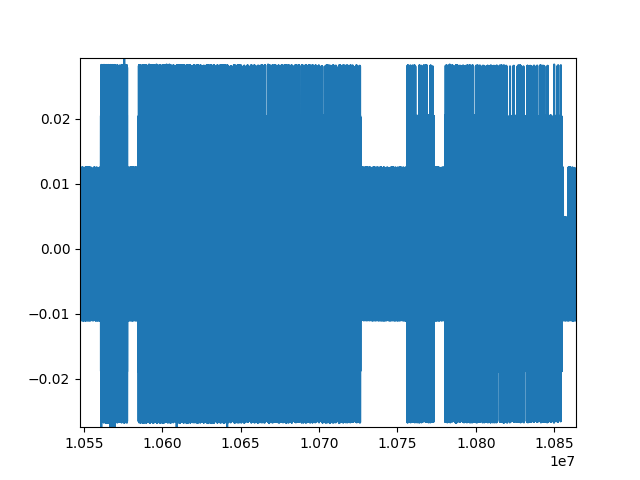

In [75]:
# plot to select one occurence
%matplotlib notebook
plt.plot(raw_data.imag)

In [76]:
# create dataframe
#raw_cut = raw_data[int(1.44e6):int(1.5e6)]
raw_cut = raw_data[int(1.055e7):int(1.09e7)]
df = pd.DataFrame(
    {
        "real": raw_cut.real,
        "imag": raw_cut.imag,
        "time": pd.date_range(timestamp, periods=len(raw_cut), freq=pd.Timedelta(seconds=1/sample_rate))
    }
)
df

,real,imag,time
0,0.001762,0.004622,2022-08-10 13:08:36.000000
1,-0.001174,-0.003082,2022-08-10 13:08:36.000001
2,0.001762,-0.003190,2022-08-10 13:08:36.000002
3,0.001762,-0.003190,2022-08-10 13:08:36.000003
4,-0.001174,-0.003082,2022-08-10 13:08:36.000004
...,...,...,...
349995,-0.001268,-0.003088,2022-08-10 13:08:36.349995
349996,-0.001268,0.004724,2022-08-10 13:08:36.349996
349997,0.001902,-0.003180,2022-08-10 13:08:36.349997
349998,-0.001268,-0.003088,2022-08-10 13:08:36.349998


<IPython.core.display.Javascript object>


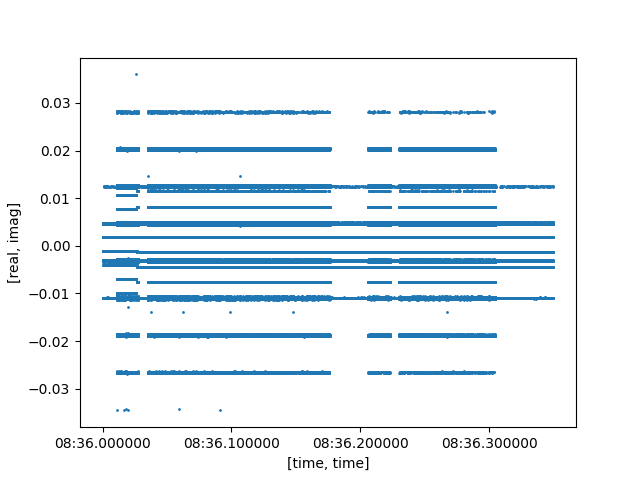

<AxesSubplot:xlabel='[time, time]', ylabel='[real, imag]'>

In [77]:
%matplotlib notebook
df.plot(["time", "time"], ["real", "imag"], kind="scatter", s=1)

<IPython.core.display.Javascript object>


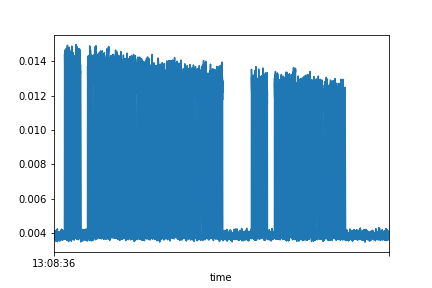

In [101]:
%matplotlib notebook
df_conditioned = df.set_index("time")["imag"].abs().rolling(window=100).mean()
df_conditioned.plot()
df_conditioned = df_conditioned.to_frame()

<IPython.core.display.Javascript object>


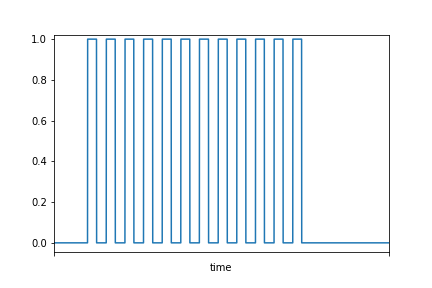

<AxesSubplot:xlabel='time'>

In [109]:
%matplotlib notebook

threshold = df_conditioned.imag.max() / 2
df_conditioned["bin"] = df_conditioned.imag.apply(lambda x: 1 if x > threshold else 0)
df_conditioned[::10].bin.plot()

In [90]:
df[::10].to_csv("szlaban u rodzicow 2022-08-10.csv")

In [107]:
df_conditioned.bin[df_conditioned.bin==1]

time
2022-08-10 13:08:36.010987    1
2022-08-10 13:08:36.010988    1
2022-08-10 13:08:36.010989    1
2022-08-10 13:08:36.010990    1
2022-08-10 13:08:36.010991    1
                             ..
2022-08-10 13:08:36.304507    1
2022-08-10 13:08:36.304508    1
2022-08-10 13:08:36.304509    1
2022-08-10 13:08:36.304510    1
2022-08-10 13:08:36.304511    1
Name: bin, Length: 128978, dtype: int64